In [12]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def standardize(stack):
    return (stack - np.mean(stack, axis=(1,2), keepdims=True)) / np.std(stack, axis=(1,2), keepdims=True)

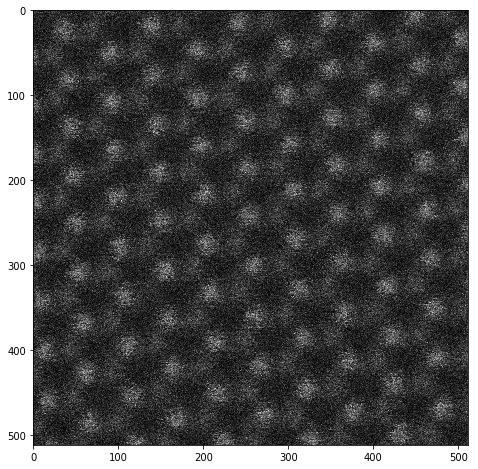

In [15]:
stack = imread('MoS2_example_series/VCR_stack_(HAADF)_series36_141116.tif')
stack = standardize(stack)

plt.figure(figsize=(8,8))
plt.imshow(stack[0], cmap='gray');

In [16]:
json_file = open('unet-small.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('mos2-v0.1.h5')

Text(0.5, 1.0, 'confidence map')

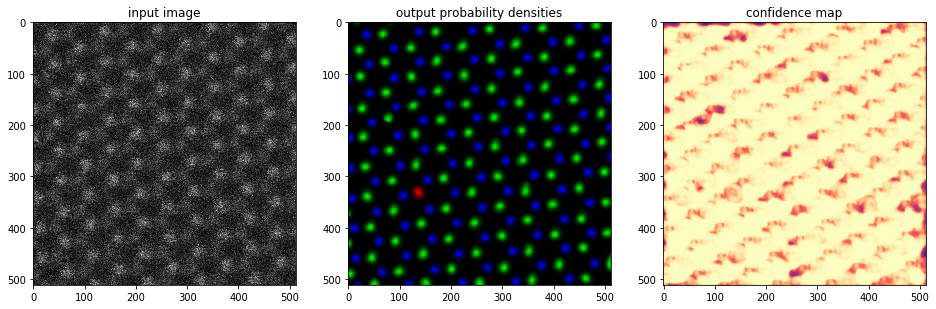

In [19]:
image = stack[0]

prediction, confidence = model.predict(image[None,...,None])

fig,(ax1,ax2,ax3)=plt.subplots(1, 3, figsize=(16, 12))
ax1.imshow(image.T, cmap='gray')
ax1.set_title('input image')
ax2.imshow(np.flip(prediction[0,...,1:],axis=-1).T)
ax2.set_title('output probability densities')
ax3.imshow(confidence[0,...,0].T, vmin=0,vmax=1,cmap='magma')
ax3.set_title('confidence map')

In [21]:
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label
from skimage.segmentation import clear_border

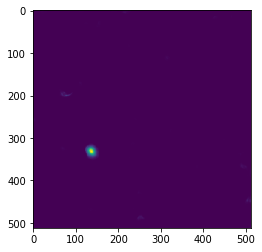

In [32]:
plt.imshow(density[..., -1])

In [36]:
density = prediction[0]

thresholded = density[..., 0] < .2
thresholded = clear_border(thresholded, 20)
label_image, num_labels = label(thresholded, return_num=True)

class_probabilities = np.zeros((num_labels - 1, density.shape[-1] - 1))

for label_num in range(1, num_labels):
    class_totals = np.sum(density[label_image == label_num, :-1], axis=0)
    class_probabilities[label_num - 1] = class_totals / np.sum(class_totals)

centers = np.array(center_of_mass(1 - density[..., -1], label_image, range(1, num_labels)))
class_ids = np.argmax(class_probabilities, axis=1)
selected_class = 0
if selected_class != 0:
    centers = centers[class_ids == selected_class - 1]
    class_ids = class_ids[class_ids == selected_class - 1]


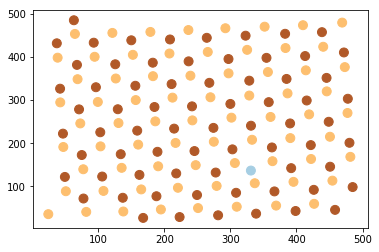

In [43]:
plt.scatter(*centers.T, c=class_ids, cmap='Paired', s=80)